In [ ]:
import os
import subprocess

import joblib
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler

## Data Preprocessing

In [17]:
def impute_df(df, bg_cols, insulin_cols, carbs_cols, hr_cols, steps_cols, cals_cols):
    
    df = df.copy()
    
    # Blood Glucose & Heart Rate: Linear Interpolation & Mean
    df[bg_cols] = df[bg_cols].apply(
        lambda row: row.interpolate(method='linear', limit_direction='both'), axis=1)
    df[bg_cols] = df[bg_cols].fillna(df[bg_cols].mean(axis=1))
    
    df[hr_cols] = df[hr_cols].apply(
        lambda row: row.interpolate(method='linear', limit_direction='both'), axis=1)
    df[hr_cols] = df[hr_cols].fillna(df[hr_cols].mean(axis=1))
    
    # Insulin and Carbs: Fill NaN w/ 0
    df[insulin_cols + carbs_cols] = df[insulin_cols + carbs_cols].fillna(0)
        
    # Steps & Calories: Fill NaN w/ 0
    df[steps_cols + cals_cols] = df[steps_cols + cals_cols].fillna(0)
    
    # Residual: Forward Fill
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    return df

In [18]:
def augment_df(df):
    
    df = df.copy()
    
    noise_factor = 0.01
    exclude_cols = ['id', 'p_num', 'time', 'bg+1:00']
    numeric_aug_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_aug_cols = [col for col in numeric_aug_cols if col not in exclude_cols]
    
    for col in numeric_aug_cols:
        std_val = df[col].std()
        df[col] = df[col] + np.random.normal(0, noise_factor * std_val, size=len(df))

    return pd.concat([df, df], ignore_index=True)

In [19]:
def select_df(df, bg_cols, insulin_cols, carbs_cols, hr_cols, steps_cols, cals_cols):
    
    df = df.copy()
    
    latest_bg_cols     = bg_cols[-24:]
    latest_insulin_cols = insulin_cols[-24:]
    latest_carbs_cols   = carbs_cols[-24:]
    latest_hr_cols      = hr_cols[-24:]
    latest_steps_cols   = steps_cols[-24:]
    latest_cals_cols    = cals_cols[-24:]
    
    latest_ts_cols = (
        latest_bg_cols +
        latest_insulin_cols +
        latest_carbs_cols +
        latest_hr_cols +
        latest_steps_cols +
        latest_cals_cols
    )

    selected_cols = ["id"] + latest_ts_cols
    if "bg+1:00" in df.columns:
        selected_cols += ["bg+1:00"]
    
    return df[selected_cols]

In [20]:
def scale_df(df):
    
    df = df.copy()
    
    target_col = 'bg+1:00'
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != target_col]
    
    feature_scaler = StandardScaler()
    df[numeric_columns] = feature_scaler.fit_transform(df[numeric_columns])

    target_scaler = StandardScaler()
    if target_col in df.columns:
        df[[target_col]] = target_scaler.fit_transform(df[[target_col]])
    
    return df, target_scaler

In [30]:
def preprocess_df(df):
    
    df = df.copy()
    
    bg_cols      = [col for col in df.columns if col.startswith("bg-")]
    insulin_cols = [col for col in df.columns if col.startswith("insulin-")]
    carbs_cols   = [col for col in df.columns if col.startswith("carbs-")]
    hr_cols      = [col for col in df.columns if col.startswith("hr-")]
    steps_cols   = [col for col in df.columns if col.startswith("steps-")]
    cals_cols    = [col for col in df.columns if col.startswith("cals-")]
    activity_cols= [col for col in df.columns if col.startswith("activity-")]

    df.drop(columns=activity_cols, inplace=True)
    

    
    # ================================
    # Data Imputation
    # ================================
    
    df_imputed = impute_df(df, bg_cols, insulin_cols, carbs_cols, hr_cols, steps_cols, cals_cols)
    
    print("NaN Values (Data Imputation):")
    print(df_imputed.isna().any().any())
    print("\n")
    
    
    
    # ================================
    # Data Augmentation
    # ================================
    
    df_augmented = augment_df(df_imputed)
    
    print("NaN Values (Data Augmentation):")
    print(df_augmented.isna().any().any())
    print("\n")
    
    
    
    # ================================
    # Data Selection
    # ================================
    
    df_selected = select_df(df_augmented, bg_cols, insulin_cols, carbs_cols, hr_cols, steps_cols, cals_cols)
    
    print("NaN Values (Data Selection):")
    print(df_selected.isna().any().any())
    print("\n")
    
    print("Columns:")
    for i in df_selected.columns:
        print(i)
    print("\n")
    
    
    
    # ================================
    # Data Scaling
    # ================================
    
    df_scaled, target_scalar = scale_df(df_selected)
    
    print("NaN Values (Data Scaling):")
    print(df_scaled.isna().any().any())
    print("\n")
    
    return df_scaled, target_scalar

### Data Importing

In [49]:
train_path = "./.data/train.csv.zip"
test_path = "./.data/test.csv"

if not os.path.exists(train_path):
    os.makedirs("./.data", exist_ok=True)
    print("Downloading BrisT1D ...")
    subprocess.run(["kaggle", "competitions", "download", "-c", "brist1d", "-p", "./.data"], check=True)

with zipfile.ZipFile(train_path) as z:
    with z.open("train.csv") as f:
        df_train = pd.read_csv(f)
            
df_test = pd.read_csv("./.data/test.csv")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_39300\2261742640.py:11: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(f)


### Data Transformation

In [25]:
print(df_train)

               id p_num      time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  \
0           p01_0   p01  06:10:00      NaN      NaN      9.6      NaN   
1           p01_1   p01  06:25:00      NaN      NaN      9.7      NaN   
2           p01_2   p01  06:40:00      NaN      NaN      9.2      NaN   
3           p01_3   p01  06:55:00      NaN      NaN      8.7      NaN   
4           p01_4   p01  07:10:00      NaN      NaN      8.4      NaN   
...           ...   ...       ...      ...      ...      ...      ...   
177019  p12_25294   p12  23:35:00      8.8      9.1      9.2      9.4   
177020  p12_25295   p12  23:40:00      9.1      9.2      9.4      9.8   
177021  p12_25296   p12  23:45:00      9.2      9.4      9.8     10.2   
177022  p12_25297   p12  23:50:00      9.4      9.8     10.2     10.4   
177023  p12_25298   p12  23:55:00      9.8     10.2     10.4     10.3   

        bg-5:35  bg-5:30  bg-5:25  ...  activity-0:40  activity-0:35  \
0           NaN      9.7      NaN  ...            N

In [23]:
df_train_preprocessed, df_train_preprocessed_scaler = preprocess_df(df_train)

NaN Values (Data Imputation):
False


NaN Values (Data Augmentation):
False


NaN Values (Data Selection):
False


Columns:
id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
h

In [24]:
print(df_train_preprocessed)

               id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0           p01_0  3.103256  3.207739  3.306019  3.338826  3.354246  3.385527   
1           p01_1  3.334344  3.368640  3.382463  3.342868  3.303760  3.241867   
2           p01_2  3.351738  3.290329  3.235490  3.198546  3.087441  2.998913   
3           p01_3  3.164014  3.096026  3.013504  3.049034  3.062024  3.092045   
4           p01_4  3.036686  3.041001  3.069754  3.055564  3.022660  2.999762   
...           ...       ...       ...       ...       ...       ...       ...   
354043  p12_25294 -0.143842 -0.166453 -0.178820 -0.190547 -0.300671 -0.393663   
354044  p12_25295 -0.173634 -0.161785 -0.186081 -0.298534 -0.412794 -0.461140   
354045  p12_25296 -0.205563 -0.200199 -0.298250 -0.389232 -0.461662 -0.512562   
354046  p12_25297 -0.188150 -0.278181 -0.400960 -0.453957 -0.532632 -0.628098   
354047  p12_25298 -0.291531 -0.394955 -0.461099 -0.537074 -0.637675 -0.692059   

         bg-1:25   bg-1:20 

In [31]:
print(df_test)

            id p_num      time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  bg-5:35  \
0     p01_8459   p01  06:45:00      NaN      9.2      NaN      NaN     10.2   
1     p01_8460   p01  11:25:00      NaN      NaN      9.9      NaN      NaN   
2     p01_8461   p01  14:45:00      NaN      5.5      NaN      NaN      5.5   
3     p01_8462   p01  04:30:00      NaN      3.4      NaN      NaN      3.9   
4     p01_8463   p01  04:20:00      NaN      NaN      8.3      NaN      NaN   
...        ...   ...       ...      ...      ...      ...      ...      ...   
3639   p24_256   p24  06:40:00      7.3      7.3      7.1      6.7      6.8   
3640   p24_257   p24  12:30:00      6.0      6.2      6.2      6.2      5.8   
3641   p24_258   p24  03:45:00     12.4     12.5     12.7     13.1     13.2   
3642   p24_259   p24  06:10:00      8.3      8.3      8.2      8.2      7.8   
3643   p24_260   p24  03:10:00      9.9     10.1     10.0      9.9     10.0   

      bg-5:30  bg-5:25  ...  activity-0:45  activit

In [32]:
df_test_preprocessed, df_test_scaler = preprocess_df(df_test)

NaN Values (Data Imputation):
False


NaN Values (Data Augmentation):
False


NaN Values (Data Selection):
False


Columns:
id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
h

In [33]:
print(df_test_preprocessed)

            id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0     p01_8459  1.490083  1.493991  1.487914  1.536848  1.543252  1.609489   
1     p01_8460 -0.484494 -0.640907 -0.822489 -0.931031 -1.038671 -1.145885   
2     p01_8461 -1.100145 -1.072103 -1.085097 -1.078083 -1.079982 -1.054271   
3     p01_8462 -1.550306 -1.599876 -1.667817 -1.612185 -1.573266 -1.524316   
4     p01_8463 -1.452215 -1.530704 -1.639879 -1.653449 -1.693813 -1.709896   
...        ...       ...       ...       ...       ...       ...       ...   
7283   p24_256 -0.755966 -0.598032 -0.511680 -0.485289 -0.589582 -0.516143   
7284   p24_257 -0.867098 -0.597732 -0.391667 -0.329957 -0.298055 -0.364247   
7285   p24_258  0.341528  0.324581  0.305170  0.260892  0.215751  0.230552   
7286   p24_259 -0.475408 -0.482376 -0.462070 -0.460022 -0.407464 -0.336393   
7287   p24_260 -0.934047 -0.964720 -0.875623 -0.866758 -0.816449 -0.743403   

       bg-1:25   bg-1:20   bg-1:15  ...  cals-0:45  cals-0:40  

### Data Exporting

In [34]:
df_train_preprocessed.to_csv("./.data/train_aug.csv", index=False)
df_test_preprocessed.to_csv("./.data/test_aug.csv", index=False)

In [35]:
joblib.dump(df_train_preprocessed_scaler, './.data/target_scaler_aug.pkl')

['./.data/target_scaler_aug.pkl']

## Exploratory Data Analysis (EDA)

In [1]:
import os
import subprocess

import joblib
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler

In [2]:
df_train_preprocessed = pd.read_csv("./.data/train_aug.csv")
df_test_preprocessed = pd.read_csv("./.data/test_aug.csv")
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')

In [3]:
df_train_preprocessed["bg+1:00"] = target_scaler.inverse_transform(
    df_train_preprocessed["bg+1:00"].values.reshape(-1, 1)
).ravel()

In [4]:
df_train_preprocessed['p_num'] = df_train_preprocessed['id'].str.extract(r"(p\d{2})")

### Descriptive Analysis

In [5]:
bg_1 = df_train_preprocessed["bg+1:00"]

In [6]:
global_stats = {
    "mean": bg_1.mean(),
    "median": bg_1.median(),
    "std_dev": bg_1.std(),
    "min": bg_1.min(),
    "max": bg_1.max(),
    "sum": bg_1.sum(),
    "count": bg_1.count(),
    "q1": bg_1.quantile(0.25),
    "q3": bg_1.quantile(0.75),
}

global_stats["IQR"] = global_stats["q3"] - global_stats["q1"]
global_stats["skewness"] = skew(bg_1, bias=False)
global_stats["kurtosis"] = kurtosis(bg_1, bias=False)

In [7]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)

print("Global Summary:")
display(pd.DataFrame([global_stats]).style.hide(axis="index"))

pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.max_colwidth")
pd.reset_option("display.width")

Global Summary:


mean,median,std_dev,min,max,sum,count,q1,q3,IQR,skewness,kurtosis
8.277045,7.700000,2.996394,2.200000,27.800000,2930471.200000,354048,6.100000,9.900000,3.800000,1.072439,1.476862


In [8]:
group_stats = df_train_preprocessed.groupby("p_num")["bg+1:00"].agg([
    ("mean", "mean"),
    ("median", "median"),
    ("std_dev", "std"),
    ("min", "min"),
    ("max", "max"),
    ("sum", "sum"),
    ("count", "count"),
    ("q1", lambda x: x.quantile(0.25, interpolation='nearest')),
    ("q3", lambda x: x.quantile(0.75, interpolation='nearest')),
])
group_stats["IQR"] = group_stats["q3"] - group_stats["q1"]

In [9]:
def compute_skew_kurt(group):
    return pd.Series({
        "skewness": skew(group["bg+1:00"], bias=False),
        "kurtosis": kurtosis(group["bg+1:00"], bias=False)
    })

skew_kurt = df_train_preprocessed.groupby("p_num").apply(compute_skew_kurt).reset_index()

In [10]:
final_stats = group_stats.reset_index().merge(skew_kurt, on="p_num")
final_stats = final_stats.sort_values("p_num")

In [11]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)

print("P_NUM Summary:")
display(final_stats.style.hide(axis="index"))

pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.max_colwidth")
pd.reset_option("display.width")

P_NUM Summary:


p_num,mean,median,std_dev,min,max,sum,count,q1,q3,IQR,skewness,kurtosis
p01,8.888781,8.100000,4.132065,2.200000,27.800000,150380.400000,16918,5.600000,11.500000,5.900000,0.795983,0.212161
p02,9.338358,8.800000,2.926912,2.200000,22.200000,483204.000000,51744,7.200000,11.000000,3.800000,0.934467,1.109589
p03,8.583080,7.900000,3.140448,2.200000,22.200000,446800.800000,52056,6.300000,10.400000,4.100000,0.955732,0.853046
p04,7.761359,7.400000,2.246039,2.200000,18.400000,383193.800000,49372,6.200000,9.000000,2.800000,0.740023,0.824720
p05,8.135582,7.800000,3.117823,2.200000,22.200000,134855.400000,16576,5.800000,10.100000,4.300000,0.697349,0.387844
p06,8.936872,8.100000,3.766668,2.900000,27.800000,149835.600000,16766,6.200000,10.800000,4.600000,1.161971,1.461914
p10,6.372932,6.000000,1.576349,2.200000,15.900000,324433.200000,50908,5.300000,7.200000,1.900000,1.122338,1.957650
p11,9.380721,9.300000,2.887701,2.200000,21.600000,460687.200000,49110,7.300000,11.300000,4.000000,0.374741,-0.034152
p12,7.847757,7.200000,2.830066,2.800000,22.200000,397080.800000,50598,6.000000,9.000000,3.000000,1.501958,3.051426


### Visual Analysis

In [12]:
df_train_preprocessed_pd = df_train_preprocessed[["p_num", "bg+1:00"]]
stats_pd = final_stats

participants = sorted(df_train_preprocessed_pd["p_num"].unique())
n = len(participants)

sns.set(style="whitegrid", palette="muted")

#### Barplot: Mean of BG+1:00/P_NUM

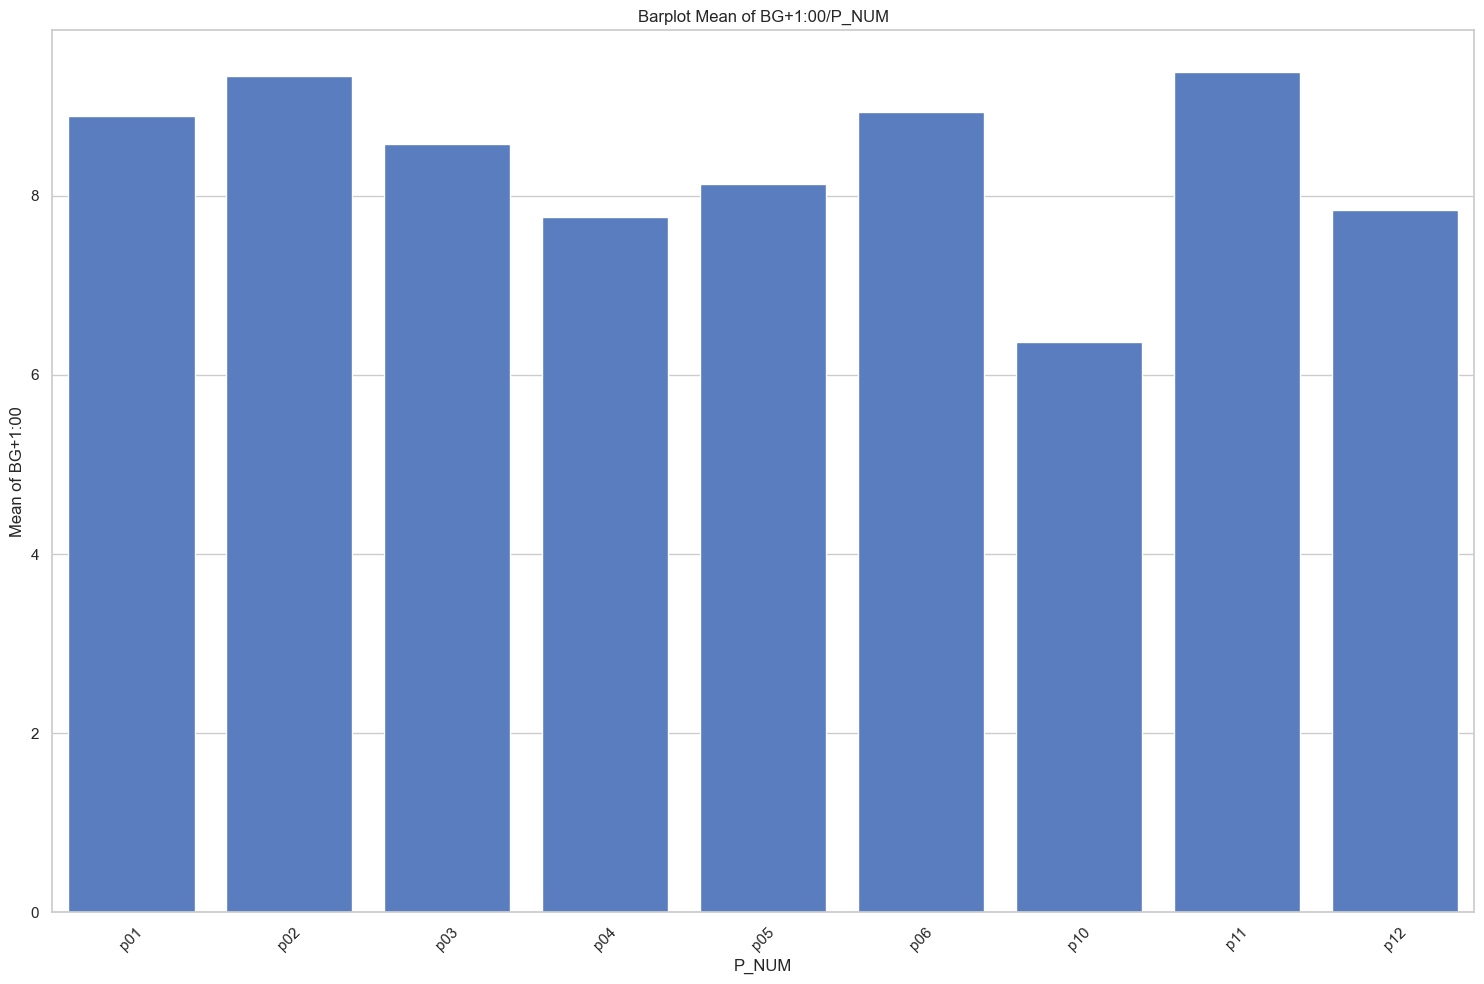

In [13]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="p_num", y="mean")
plt.title("Barplot Mean of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("Mean of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Barplot: Interquartile Range (IQR) of BG+1:00/P_NUM

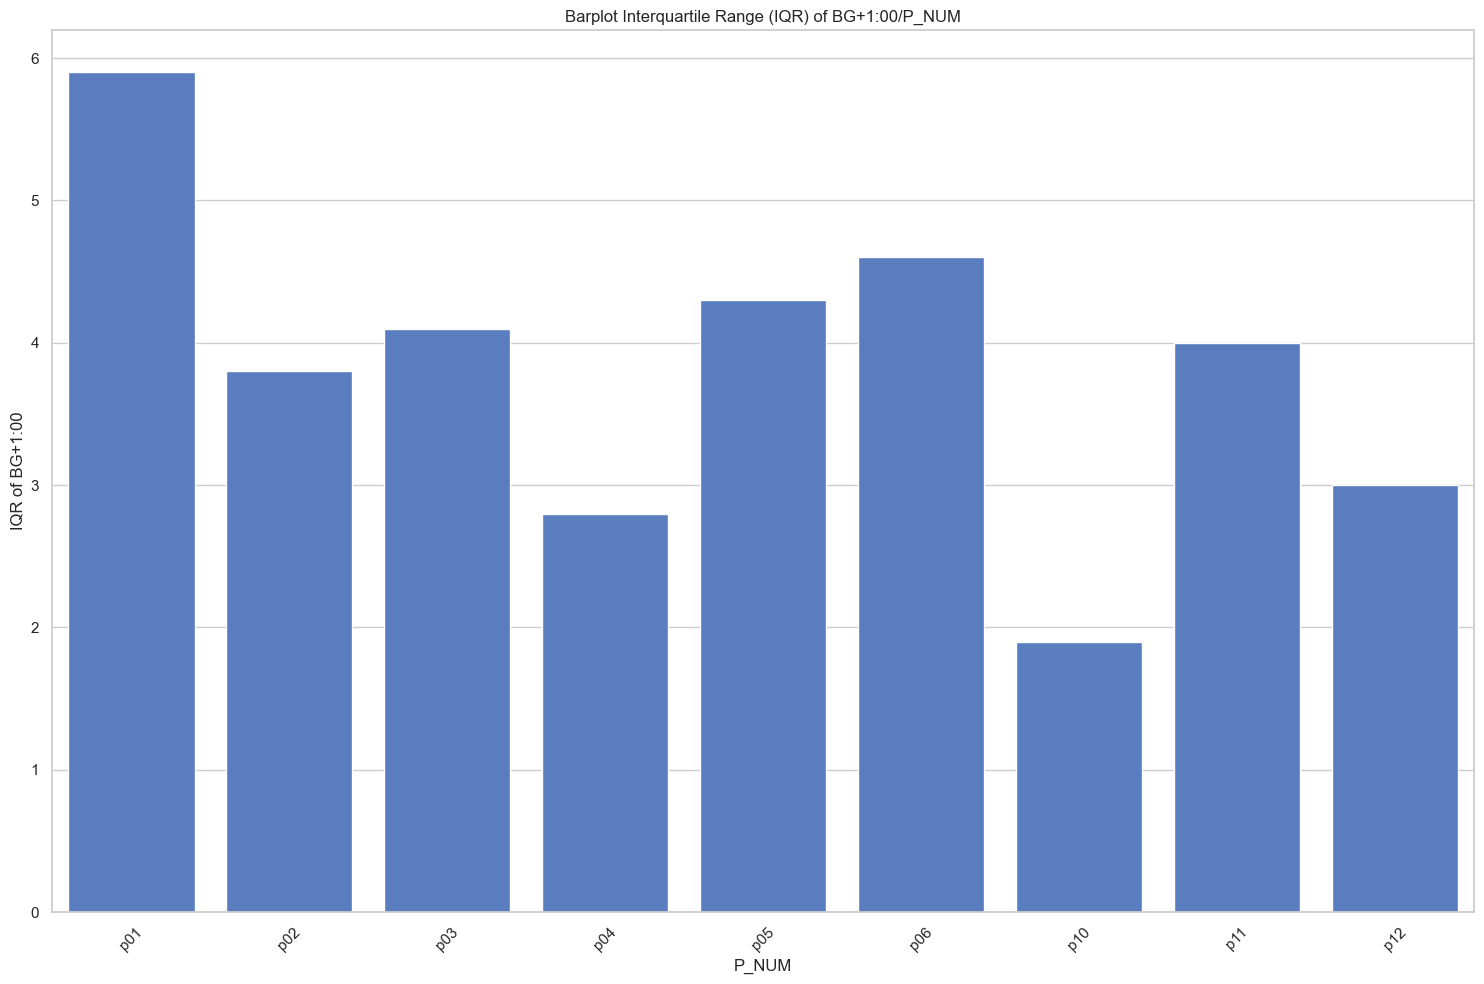

In [14]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="p_num", y="IQR")
plt.title("Barplot Interquartile Range (IQR) of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("IQR of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Barplot: Standard Deviation (SD) of BG+1:00/P_NUM

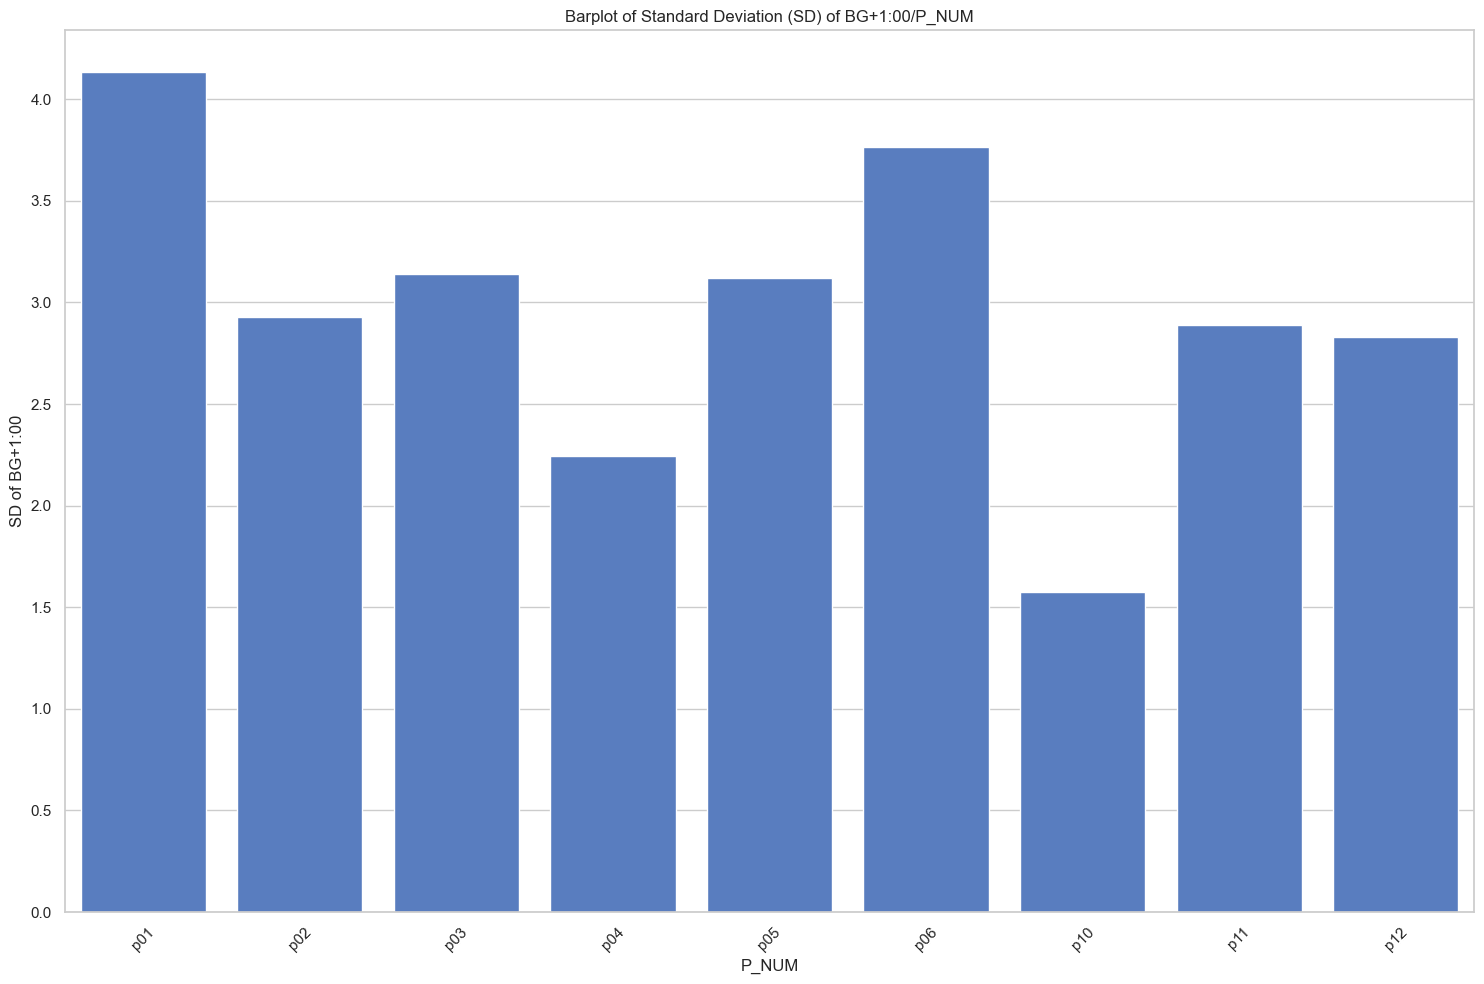

In [15]:
plt.figure(figsize=(15, 10))
sns.barplot(data=stats_pd, x="p_num", y="std_dev")
plt.title("Barplot of Standard Deviation (SD) of BG+1:00/P_NUM")
plt.xlabel("P_NUM")
plt.ylabel("SD of BG+1:00")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Scatterplot: Skewness vs. Kurtosis of BG+1:00/P_NUM

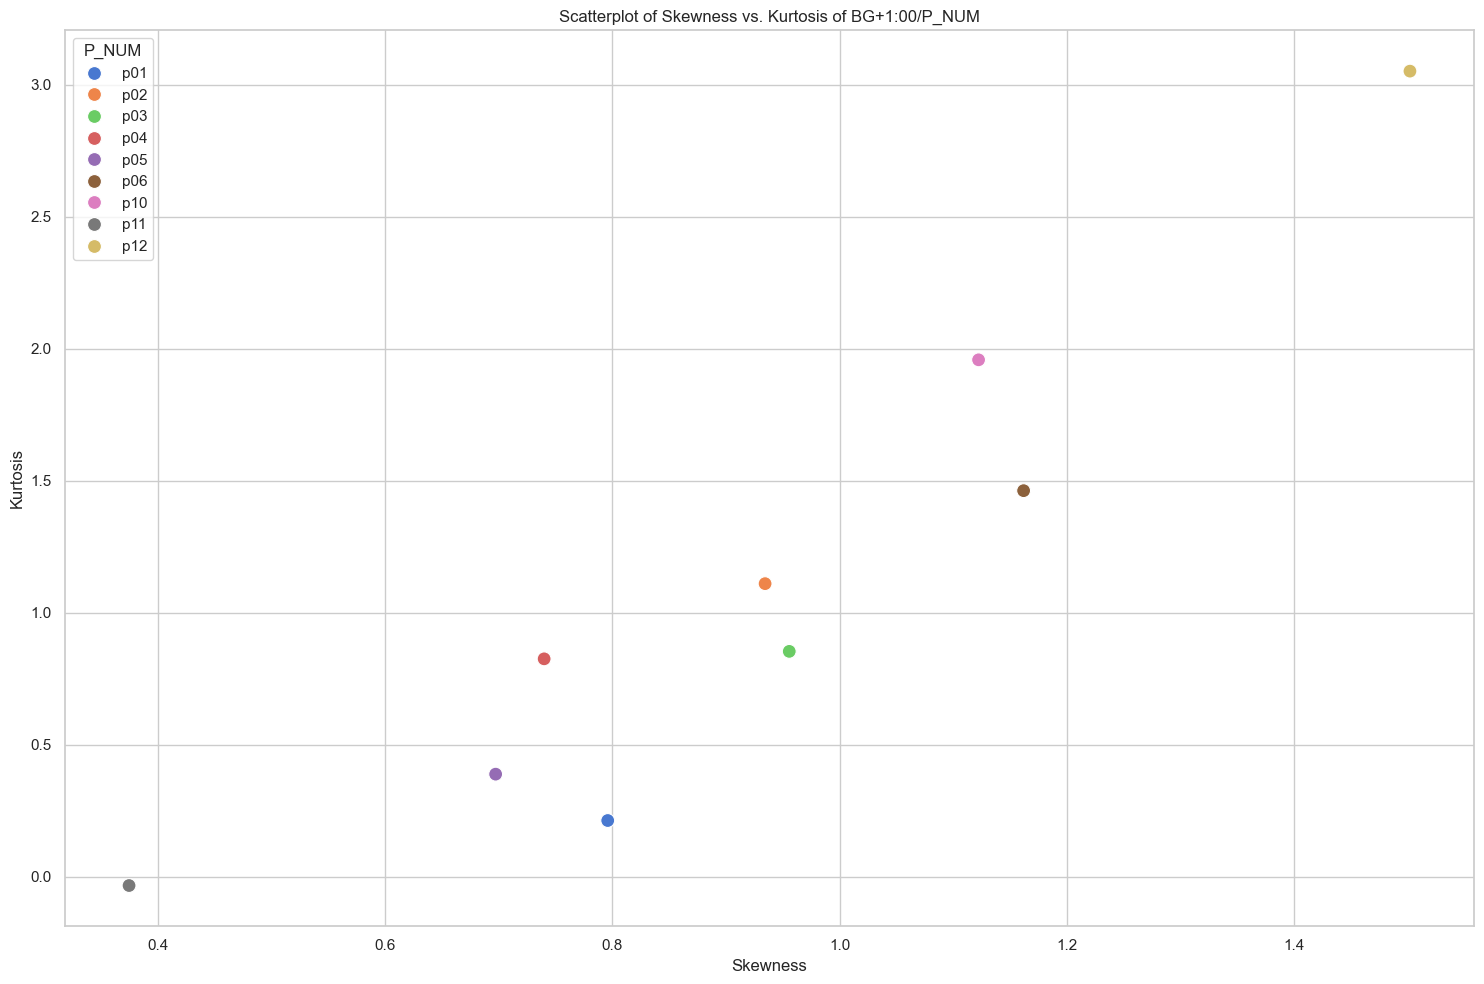

In [16]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=stats_pd, x="skewness", y="kurtosis", hue="p_num", s=100)
plt.title("Scatterplot of Skewness vs. Kurtosis of BG+1:00/P_NUM")
plt.xlabel("Skewness")
plt.ylabel("Kurtosis")
plt.legend(title="P_NUM")
plt.tight_layout()
plt.show()

#### Boxplot: BG+1:00/P_NUM

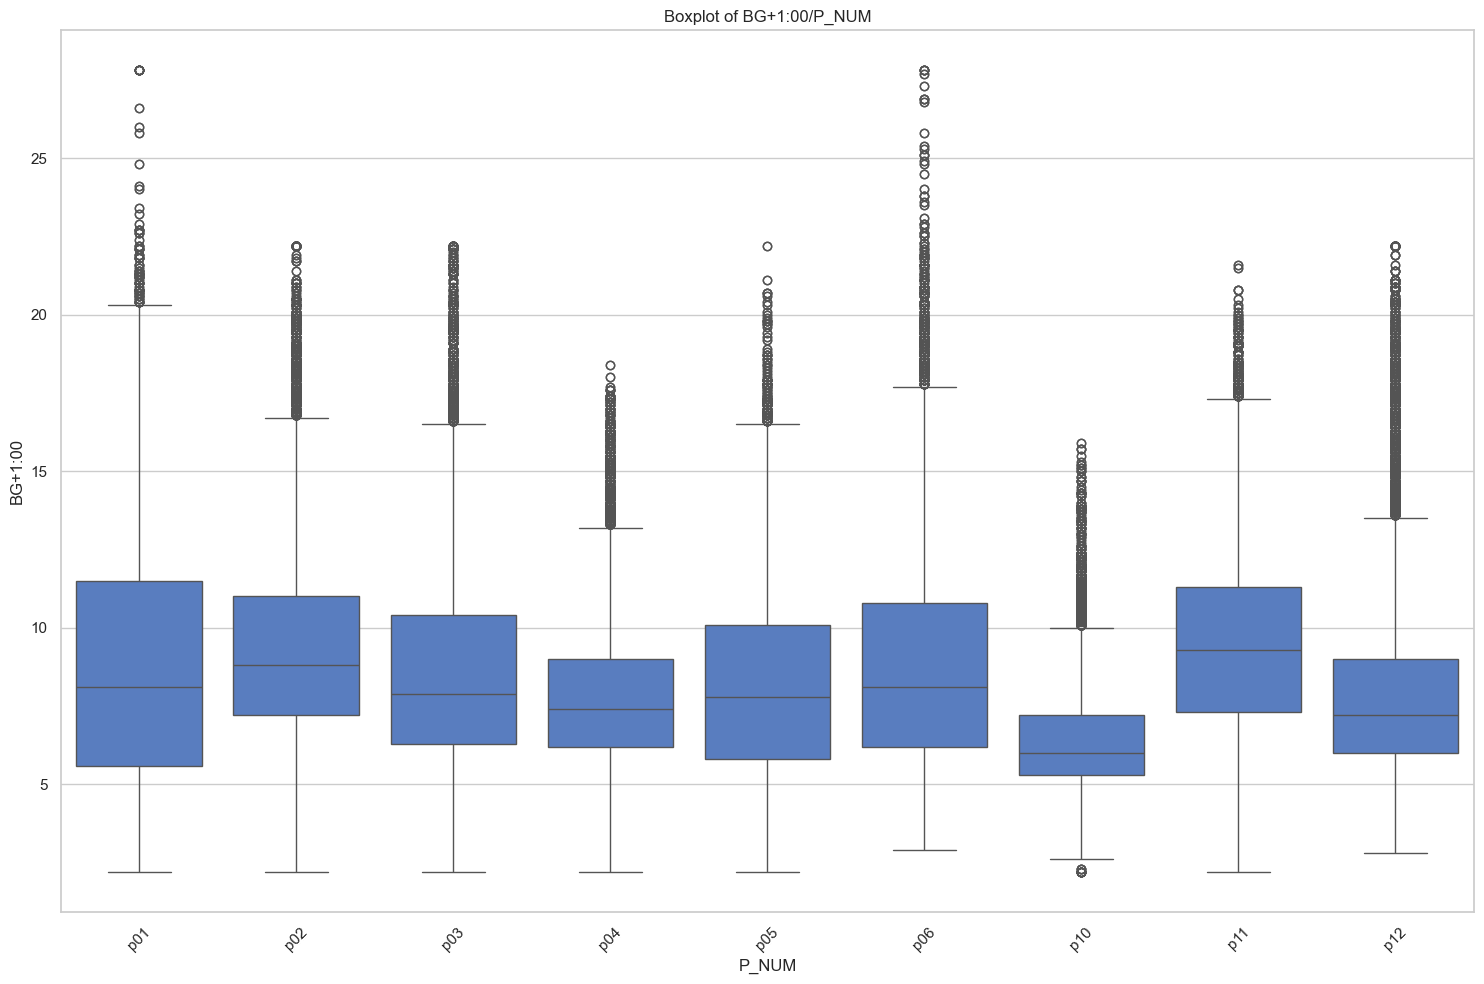

In [17]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_train_preprocessed_pd, x="p_num", y="bg+1:00")
plt.title("Boxplot of BG+1:00/P_NUM")
plt.ylabel("BG+1:00")
plt.xlabel("P_NUM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Histogram: BG+1:00/P_NUM

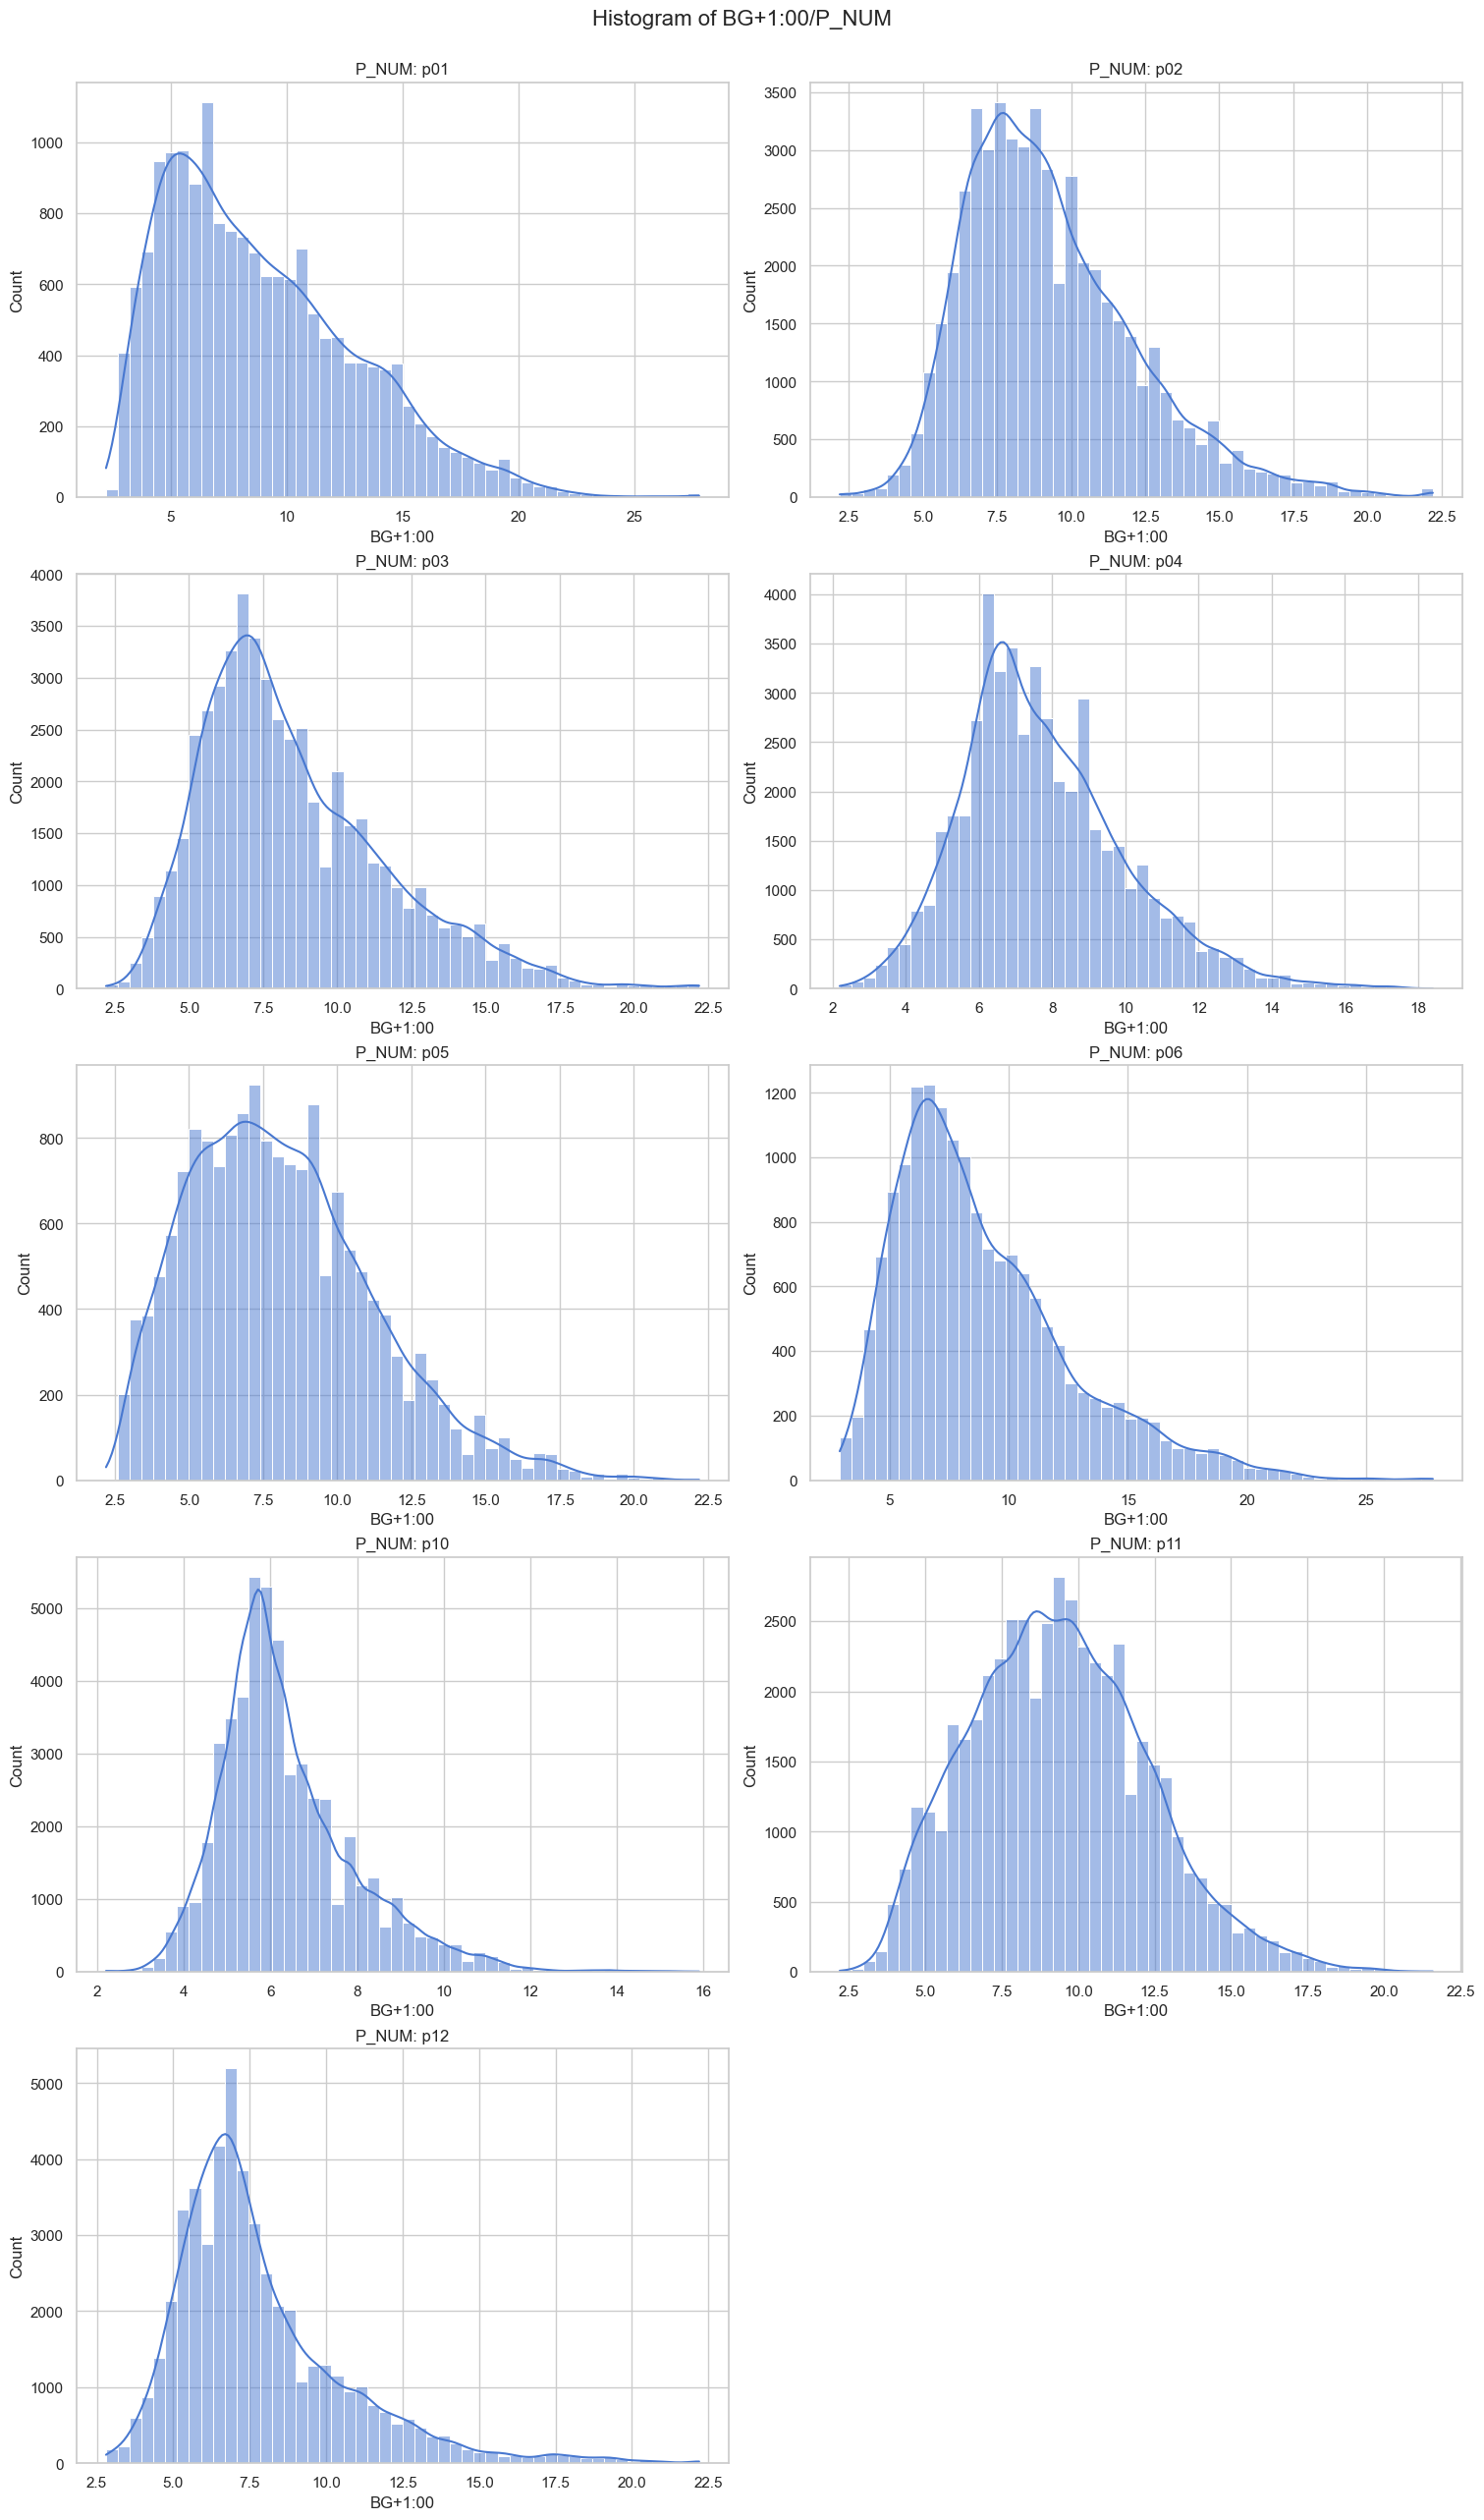

In [18]:
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5), constrained_layout=True)

axes = axes.flatten()

for idx, pid in enumerate(participants):
    subset = df_train_preprocessed_pd[df_train_preprocessed_pd["p_num"] == pid]
    ax = axes[idx]
    sns.histplot(subset["bg+1:00"], bins=50, kde=True, ax=ax)
    ax.set_title(f"P_NUM: {pid}")
    ax.set_xlabel("BG+1:00")
    ax.set_ylabel("Count")

for ax in axes[len(participants):]:
    ax.set_visible(False)

plt.suptitle("Histogram of BG+1:00/P_NUM", fontsize=16, y=1.02)
plt.show()